# Species Selection

## Introduction
This notebook documents the first stage of the research process: gathering species trait data and preparing it for multidimensional trait analysis. We will also perform initial exploratory data analysis and cluster the species based on their life-history traits.

This analysis focuses on six amphibian species in Central Scotland:
- ***Bufo bufo*** (Common Toad)
- ***Lissotriton helveticus*** (Palmate Newt)
- ***Lissotriton vulgaris*** (Smooth Newt)
- ***Rana temporaria*** (Common Frog)
- ***Triturus cristatus*** (Great Crested Newt)
- ***Ichtyosaura alpestris*** (Alpine Newt)
  
## Methodology Overview

This analysis aims to evaluate amphibian species traits and identify clusters of species with similar ecological requirements. The following key methodologies are applied:

1. **Multidimensional Trait Analysis**: This technique analyzes species' ecological traits, such as body size, number of eggs, and diet, to understand how species differ in their life-history strategies.

2. **Principal Component Analysis (PCA)**: PCA is a dimensionality reduction technique that simplifies complex datasets by identifying the most important components (directions of variation) in the data. This allows us to visualize the relationships between species based on their ecological traits in a reduced number of dimensions.

3. **Agglomerative Clustering with Euclidean Distance**: Agglomerative hierarchical clustering is used to group species into clusters based on similarity in their traits. It operates by successively merging the closest pairs of clusters. The `Euclidean distance` metric is used to measure the similarity between species, ensuring that clusters are formed based on species that share similar ecological traits.

4. **Data Standardization**: Since species traits are measured in different units (e.g., body size in millimeters, egg count in thousands), it is essential to standardize the data so that traits with larger numerical ranges do not disproportionately influence the analysis. Standardization ensures that each trait contributes equally to the analysis.


The goal of this notebook is to ensure that the data is properly prepared and ready for further analysis, including PCA and cluster analysis.

# Step 1: Importing Necessary Libraries
We begin by importing essential Python libraries such as pandas, numpy, matplotlib, and seaborn.


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Step 2: Loading the Species Trait Data  
The species trait data is adapted from [Trochet et al. (2014)](https://bdj.pensoft.net/articles.php?id=4123) and organized in the matrix below. The data is loaded into a pandas `DataFrame` for easy manipulation. This matrix includes key traits such as body mass, metamorphosis size, number of eggs, juvenile diet composition, displacement mode, and dispersal distance. These traits serve as the basis for the multidimensional trait analysis, using methods like PCA and cluster analysis.



In [3]:
import pandas as pd

# Updated species trait data
species_traits = {
    'Species': ['Bufo bufo', 'Lissotriton helveticus', 'Lissotriton vulgaris', 
                'Rana temporaria', 'Triturus cristatus', 'Ichtyosaura alpestris'],
    'Mass_g': [76.54, 1.30, 1.50, 22.00, 18.00, 14.00],
    'Meta_Size_mm': [11.75, 35, 39.67, 13.75, 61.25, 47.86],
    'Eggs_Number': [3000, 460, 300, 2000, 200, 260],
    'Diet': [
        'Herbivorous, transitioning to omnivorous', 
        'Carnivorous (crustacea, insects)', 
        'Carnivorous (crustacea, insects)', 
        'Herbivorous, transitioning to omnivorous', 
        'Carnivorous (crustacea, insects)', 
        'Carnivorous (crustacea, insects)'
    ],
    'Displacement': [
        'Terrestrial Vertical', 
        'Aquatic & Terrestrial', 
        'Aquatic & Terrestrial', 
        'Terrestrial & Aquatic', 
        'Aquatic & Terrestrial', 
        'Aquatic'
    ],
    'Dispersal_m': [5000, 1000, 1000, 2000, 1300, 1000],
    'Source': [
        'Egg count adjusted (Evans, as cited in Smith, 1964, p. 104), diet from McInerny & Minting (2016), dispersal from Baker et al. (2011, p. 44)',
        'Diet from Jehle et al. (2011, p.67), dispersal from Baker et al. (2011, p. 44)',
        'Diet from Jehle et al. (2011, p. 67), dispersal from Baker et al. (2011, p. 44)',
        'Egg count adjusted using original records discussed in Smith (1964, p.134), diet from McInerny & Minting (2016), dispersal from Baker et al. (2011, p. 44)',
        'Diet from Jehle et al. (2011), dispersal from Baker et al. (2011, p. 44)',
        'Diet from Jehle et al. (2011), dispersal from Baker et al. (2011, p. 44)'
    ]
}

# Create DataFrame
df = pd.DataFrame(species_traits)
df


,Species,Mass_g,Meta_Size_mm,Eggs_Number,Diet,Displacement,Dispersal_m,Source
0,Bufo bufo,76.54,11.75,3000,"Herbivorous, transitioning to omnivorous",Terrestrial Vertical,5000,"Egg count adjusted (Evans, as cited in Smith, ..."
1,Lissotriton helveticus,1.30,35.00,460,"Carnivorous (crustacea, insects)",Aquatic & Terrestrial,1000,"Diet from Jehle et al. (2011, p.67), dispersal..."
2,Lissotriton vulgaris,1.50,39.67,300,"Carnivorous (crustacea, insects)",Aquatic & Terrestrial,1000,"Diet from Jehle et al. (2011, p. 67), dispersa..."
3,Rana temporaria,22.00,13.75,2000,"Herbivorous, transitioning to omnivorous",Terrestrial & Aquatic,2000,Egg count adjusted using original records disc...
4,Triturus cristatus,18.00,61.25,200,"Carnivorous (crustacea, insects)",Aquatic & Terrestrial,1300,"Diet from Jehle et al. (2011), dispersal from ..."
5,Ichtyosaura alpestris,14.00,47.86,260,"Carnivorous (crustacea, insects)",Aquatic,1000,"Diet from Jehle et al. (2011), dispersal from ..."


# Step 3: Data Preparation

In this step, we prepare the species trait data for PCA and clustering analysis. Categorical variables, such as `juvenile diet composition` and `displacement mode`, are converted into a numerical format using **one-hot encoding**. This process creates binary columns that represent each category of the original categorical variables.

Next, we standardize the numerical features, including `body mass`, `metamorphosis size`, `number of eggs`, and `dispersal distance`, to ensure each variable contributes equally to the analysis. **Standardization** is essential because it scales all features to have a mean of 0 and a standard deviation of 1, preventing variables with larger numerical ranges (e.g., body mass) from dominating the analysis. The standardized data is then ready for Principal Component Analysis (PCA) and clustering.
.


In [4]:
# Perform one-hot encoding on categorical columns such as 'Diet' and 'Displacement'
encoder = OneHotEncoder(sparse_output=False)  # Updated to sparse_output=False
encoded_features = encoder.fit_transform(df[['Diet', 'Displacement']])

# Convert the array back to a DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Diet', 'Displacement']))

# Concatenate the encoded DataFrame back to the original (without 'Diet' and 'Displacement')
df_encoded = pd.concat([df.drop(['Diet', 'Displacement', 'Source'], axis=1), encoded_df], axis=1)

# Now drop 'Species' and 'Source' columns as they are not needed for PCA
df_features = df_encoded.drop(['Species'], axis=1)

# Standardize the features before PCA
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_features)

# Create a DataFrame with the standardized features
df_scaled = pd.DataFrame(features_scaled, columns=df_features.columns)

# Show the prepared and scaled data ready for PCA and cluster analysis
df_scaled

,Mass_g,Meta_Size_mm,Eggs_Number,Dispersal_m,"Diet_Carnivorous (crustacea, insects)","Diet_Herbivorous, transitioning to omnivorous",Displacement_Aquatic,Displacement_Aquatic & Terrestrial,Displacement_Terrestrial & Aquatic,Displacement_Terrestrial Vertical
0,2.129642,-1.310778,1.822761,2.167251,-1.414214,1.414214,-0.447214,-1.0,-0.447214,2.236068
1,-0.820360,0.006800,-0.535378,-0.614248,0.707107,-0.707107,-0.447214,1.0,-0.447214,-0.447214
2,-0.812518,0.271449,-0.683922,-0.614248,0.707107,-0.707107,-0.447214,1.0,-0.447214,-0.447214
3,-0.008756,-1.197438,0.894360,0.081127,-1.414214,1.414214,-0.447214,-1.0,2.236068,-0.447214
4,-0.165588,1.494389,-0.776762,-0.405635,0.707107,-0.707107,-0.447214,1.0,-0.447214,-0.447214
5,-0.322420,0.735577,-0.721058,-0.614248,0.707107,-0.707107,2.236068,-1.0,-0.447214,-0.447214


Here, we have:
- **Encoded** the categorical variables (`Juvenile_Diet` and `Displacement_Mode`) into numerical format using one-hot encoding.
- **Standardized** the numerical features (`Mass_g`, `Meta_Size_mm`, `Eggs_Number`, `Dispersal_Distance_m`) to have zero mean and unit variance, ensuring each trait contributes equally to the analysis.

# Step 4: Principal Component Analysis (PCA)

In this step, we perform PCA on the standardized species trait data. PCA reduces the dataset's dimensionality, creating new variables (principal components) that explain the maximum variance in the data. For this analysis, we reduce the data to two principal components (PC1 and PC2) for visualization purposes. 

## How PCA Helps

- **Dimension Reduction**: Originally, the data had multiple traits (such as body mass, metamorphosis size, number of eggs, etc.), each measured on a different scale. PCA simplifies this by reducing the number of variables (dimensions) while retaining as much of the important information as possible.
  
- **Visualizing Data**: By using the first two principal components (PC1 and PC2), we can plot the species in a 2D space. This helps us understand which species are more similar or different based on their ecological traits.

## PCA Scores

In [5]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA (already standardized features from previous steps)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_scaled)

# Create a DataFrame for the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Species'] = df['Species']

# Display the principal components in numerical form
print("Principal Components for each species:")
print(pca_df)

Principal Components for each species:
        PC1       PC2                 Species
0  4.660913 -1.715062               Bufo bufo
1 -1.677589 -0.038475  Lissotriton helveticus
2 -1.822478 -0.090637    Lissotriton vulgaris
3  2.378481  2.637849         Rana temporaria
4 -1.979742 -0.600129      Triturus cristatus
5 -1.559585 -0.193545   Ichtyosaura alpestris


## PCA Loadings

PCA Loadings:
                                                    PC1       PC2
Mass_g                                         0.340942 -0.330706
Meta_Size_mm                                  -0.340350 -0.191584
Eggs_Number                                    0.387017 -0.007632
Dispersal_m                                    0.356301 -0.297016
Diet_Carnivorous (crustacea, insects)         -0.374550 -0.189922
Diet_Herbivorous, transitioning to omnivorous  0.374550  0.189922
Displacement_Aquatic                          -0.104965 -0.050387
Displacement_Aquatic & Terrestrial            -0.274893 -0.141504
Displacement_Terrestrial & Aquatic             0.160079  0.686727
Displacement_Terrestrial Vertical              0.313693 -0.446492


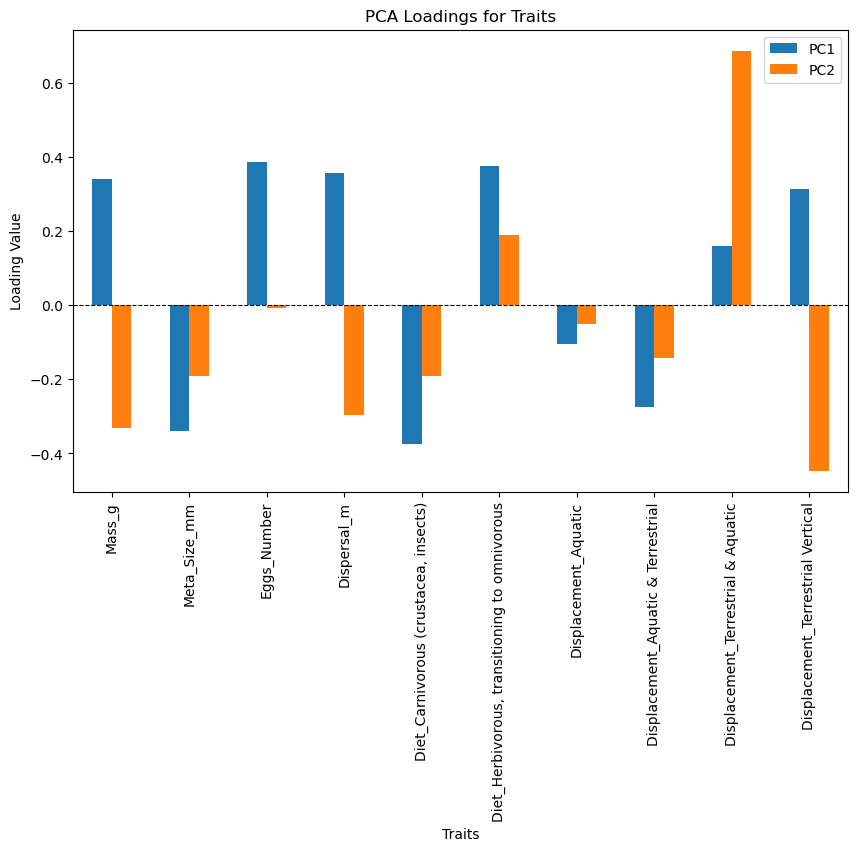

In [7]:
# Get PCA loadings (coefficients of the original variables in the principal components)
loadings = pd.DataFrame(
    data=pca.components_.T,  # Transpose to align traits with PCs
    columns=['PC1', 'PC2'],  # Principal component names
    index=df_features.columns  # Original trait names
)

# Display the loadings
print("PCA Loadings:")
print(loadings)

# Visualize the loadings as a bar plot
loadings.plot(kind='bar', figsize=(10, 6))
plt.title("PCA Loadings for Traits")
plt.ylabel("Loading Value")
plt.xlabel("Traits")
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend(loc='upper right')
plt.show()

## Principal Variance Ratio
The `explained_variance_ratio_` represents how much of the total variation in the species traits is captured by each of the principal components (PCs). In PCA, **PC1** (the first principal component) typically captures the largest portion of the variance, followed by **PC2** (the second principal component), and so on. These principal components are new variables that summarize the data in ways that make it easier to understand.

In [14]:
# Display the explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio for each component:")
print(explained_variance)

Explained Variance Ratio for each component:
[0.66447839 0.17178323]


This will give us the proportion of variance explained by each component, which helps to determine the importance of each component in summarizing the species trait data.

## Key Concepts
- **Principal Components**: PCA identifies new axes (principal components) that capture the most variation in the data. These axes are ranked by the amount of variance they explain.
  
- **Explained Variance**: Each principal component represents a certain percentage of the total variance in the dataset. The **explained variance ratio** tells us how much of the total variability is captured by each principal component. For example, if **PC1** explains 60% of the variance, it means that the first principal component alone accounts for 60% of the overall variation in the species traits.

- **Dimension Reduction**: By reducing the dataset to a smaller number of dimensions (in this case, two principal components), we make it easier to visualize and understand the data, while retaining the most important information.

In this analysis, we've reduced the dataset's complexity by identifying the principal components that explain the most variation in the traits of the species. We can now visualize how the species differ based on these reduced dimensions.

| Species                               | PC1        | PC2        |
|---------------------------------------|------------|------------|
| *Bufo bufo* (Common Toad)              | 4.660913   | -1.715062  |
| *Lissotriton helveticus* (Palmate Newt) | -1.677589  | -0.038475  |
| *Lissotriton vulgaris* (Smooth Newt)    | -1.822478  | -0.090637  |
| *Rana temporaria* (Common Frog)        | 2.378481   | 2.637849   |
| *Triturus cristatus* (Great Crested Newt) | -1.979742 | -0.600129  |
| *Ichtyosaura alpestris* (Alpine Newt)  | -1.559585  | -0.193545  |


### Observations

-  `P1 (Principal Component 1)` captures the **greatest variation** in the species trait data. It serves as the *primary axis of differentiation* between species, highlighting the major differences in traits such as body mass, egg count, and other ecological characteristics.
    - The values for PC1 indicate how much each species deviates along this axis, with **higher values** representing species with traits that are more distinct compared to others.
  
- `PC2 (Principal Component 2)` captures the **second-most variation** in the data. It serves as the *secondary axis of differentiation*, revealing patterns that differentiate species based on traits not as prominent in PC1.
    - Species with similar PC1 values might show significant differences along PC2, indicating subtle ecological or life-history trait variations.

#### Example Observations:
- *Bufo bufo (Common Toad)* is positioned at one extreme of **PC1** with a high value (`4.660`). This suggests it exhibits traits that significantly distinguish it from species with lower **PC1** values.
- *Rana temporaria (Common Frog)* is positioned at the opposite extreme of **PC1** with a value of (`2.378`), showing a different set of traits compared to the *Common Toad*.
- Along **PC2**, species like *Rana temporaria (Common Frog)* and *Ichtyosaura alpestris (Alpine Newt)* have positive values, indicating they share `secondary traits` that differentiate them from other species along this axis.
- *Lissotriton helveticus (Palmate Newt)* and *Lissotriton vulgaris (Smooth Newt)* have relatively low **PC1** and **PC2** values, suggesting their traits place them closer to each other, but still distinct from species like the *Common Toad* and *Common Frog*.
- *Triturus cristatus (Great Crested Newt)* exhibits negative values on both **PC1** (`-1.979`) and **PC2** (`-0.600`), indicating it shares traits more similar to *Lissotriton* species, but with some distinction.

# Step 5: Results Visualization

To better understand the relationships between species based on their traits, we will plot the results of the PCA. Each species will be positioned based on their values for the first two principal components (`PC1` and `PC2`). This allows us to observe patterns and clusters of species with similar ecological traits, as well as to see how different species are positioned relative to one another along the principal component axes.


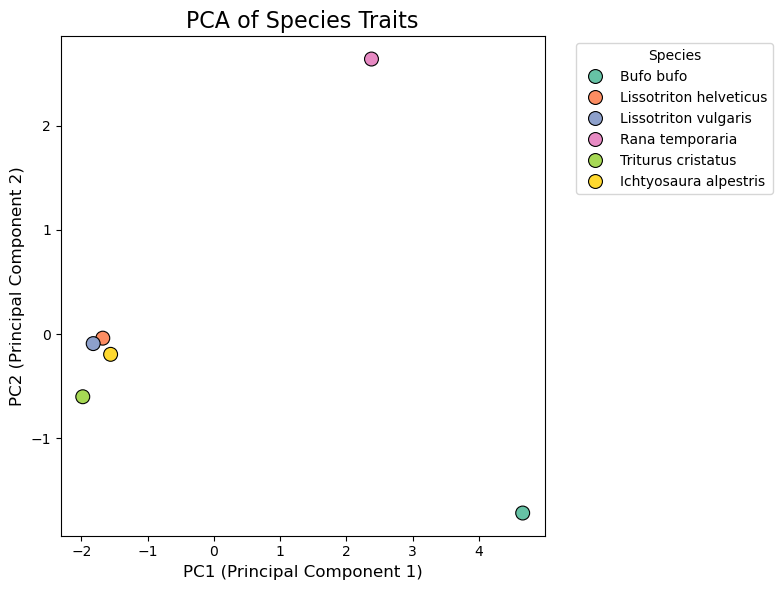

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot
plt.figure(figsize=(8, 6))

# Plot the PCA results as a scatter plot
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Species', palette='Set2', s=100, edgecolor='black')

# Customize the plot
plt.title('PCA of Species Traits', fontsize=16)
plt.xlabel('PC1 (Principal Component 1)', fontsize=12)
plt.ylabel('PC2 (Principal Component 2)', fontsize=12)
plt.legend(title='Species', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()


#### Key Insights from the Visualization:
- The scatter plot visualizes each species based on their values for PC1 and PC2. The axes represent the principal components, and their labels show the percentage of variance explained by each component.
- Species that are close together in the plot share similar ecological or life-history traits.
- The scatter plot helps us visualize how different species relate to each other in terms of their principal components and provides insights into whether there are distinct groups of species that share similar traits.es.


# Step 6: Species Selection through Cluster Analysis

Cluster analysis is a method of unsupervised machine learning that groups similar data points based on certain features or distances. This technique is valuable for understanding the structure of data and discovering inherent patterns without predefined labels. In this analysis, we use **Agglomerative Clustering**, a specific type of hierarchical clustering method.

## Key Concepts

- **Cluster Analysis**: The process of grouping similar data points together. Clustering algorithms organize data into clusters based on the similarity or distance between points.
  
- **Agglomerative Clustering**: A bottom-up approach to hierarchical clustering, where each data point starts as its own cluster. These individual clusters are progressively merged based on their similarity until all data points belong to one single cluster or the desired number of clusters is reached.

- **Euclidean Distance**: The standard distance metric used to calculate the distance between two points in space. In the case of our analysis, Euclidean distance measures how far apart two species are based on their principal component values (PC1 and PC2).

- **Linkage Criterion**: The method used to calculate the distance between clusters. In this analysis, we use **Ward's linkage**, which minimizes the total within-cluster variance. This method merges the two clusters that lead to the smallest increase in the total variance.

## Agglomerative Clustering with Ward’s Linkage

In the context of our analysis, after performing **Principal Component Analysis (PCA)**, we applied **Agglomerative Clustering** to group the species based on their trait similarities in the reduced PCA space (PC1 and PC2). The steps are as follows:

1. **Initial Step**: Start by treating each species as its own cluster.
2. **Distance Calculation**: Use **Euclidean distance** to compute the distance between clusters. The Euclidean distance between two points is calculated as:
   
   $$
   d = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}
   $$
   
   where $x_1, y_1$ and $x_2, y_2$  are the coordinates of two data points in the PCA space (PC1, PC2).
   
3. **Agglomeration**: At each step, the two closest clusters are merged based on the smallest distance between them. This process continues until the desired number of clusters is achieved or all points are grouped into one large cluster.
   
4. **Ward’s Linkage**: In Ward’s method, the algorithm merges clusters by minimizing the increase in total within-cluster variance. This approach tends to create clusters that are compact and homogeneous in terms of the data points they contain.

In [19]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering

# Step 1: Perform Agglomerative Clustering with Ward linkage
clustering = AgglomerativeClustering(n_clusters=3, linkage='ward')  # You can adjust n_clusters

# Step 2: Fit the clustering model to the PCA data (PC1 and PC2)
pca_df['Cluster'] = clustering.fit_predict(pca_df[['PC1', 'PC2']])

# Step 3: Display the clustering results
print("\nClustering Results:")
print(pca_df[['Species', 'PC1', 'PC2', 'Cluster']])

# Optionally, you can sort the clusters based on the cluster number or other features
sorted_clusters = pca_df.sort_values(by='Cluster')

# Displaying the sorted species by cluster
print("\nSorted Species by Cluster:")
print(sorted_clusters[['Species', 'PC1', 'PC2', 'Cluster']])

# Identify species in each cluster
cluster_summary = pca_df.groupby('Cluster')['Species'].apply(list).reset_index()
print("\nSpecies in Each Cluster:")
print(cluster_summary)


Clustering Results:
                  Species       PC1       PC2  Cluster
0               Bufo bufo  4.660913 -1.715062        2
1  Lissotriton helveticus -1.677589 -0.038475        0
2    Lissotriton vulgaris -1.822478 -0.090637        0
3         Rana temporaria  2.378481  2.637849        1
4      Triturus cristatus -1.979742 -0.600129        0
5   Ichtyosaura alpestris -1.559585 -0.193545        0

Sorted Species by Cluster:
                  Species       PC1       PC2  Cluster
1  Lissotriton helveticus -1.677589 -0.038475        0
2    Lissotriton vulgaris -1.822478 -0.090637        0
4      Triturus cristatus -1.979742 -0.600129        0
5   Ichtyosaura alpestris -1.559585 -0.193545        0
3         Rana temporaria  2.378481  2.637849        1
0               Bufo bufo  4.660913 -1.715062        2

Species in Each Cluster:
   Cluster                                            Species
0        0  [Lissotriton helveticus, Lissotriton vulgaris,...
1        1                     

## Cluster Visualisation

We can also visualise these results through the scatter graph below:

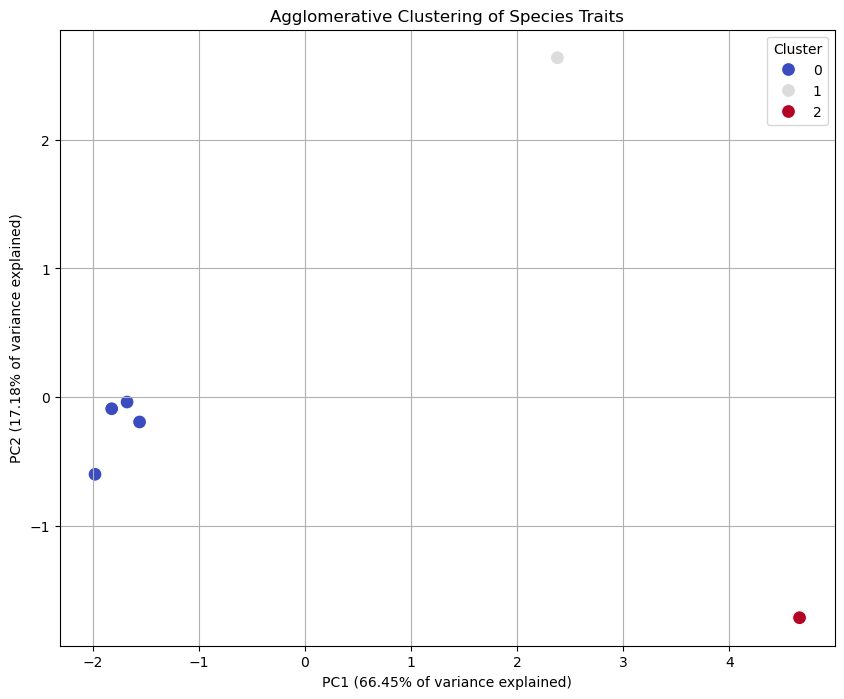

In [20]:
# Import necessary libraries for clustering and visualization
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import matplotlib.pyplot as plt

# Example PCA DataFrame (replace with your actual DataFrame)
pca_df = pd.DataFrame({
    'Species': ['Bufo bufo', 'Lissotriton helveticus', 'Lissotriton vulgaris', 'Rana temporaria', 
                'Triturus cristatus', 'Ichtyosaura alpestris'],
    'PC1': [4.660913, -1.677589, -1.822478, 2.378481, -1.979742, -1.559585],
    'PC2': [-1.715062, -0.038475, -0.090637, 2.637849, -0.600129, -0.193545],
    'Cluster': [2, 0, 0, 1, 0, 0]
})

# Perform Agglomerative Clustering
X = pca_df[['PC1', 'PC2']].values  # Use PCA components (PC1 and PC2)

agg_clust = AgglomerativeClustering(n_clusters=3, linkage='ward')  # No need for affinity='euclidean'
pca_df['Cluster'] = agg_clust.fit_predict(X)

# Plotting the hierarchical clustering results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='coolwarm', s=100)

# Title and labels
plt.title('Agglomerative Clustering of Species Traits')
plt.xlabel(f'PC1 ({explained_variance[0]*100:.2f}% of variance explained)')
plt.ylabel(f'PC2 ({explained_variance[1]*100:.2f}% of variance explained)')
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

# Step 7: Interpreting Results
## Interpretation of Agglomerative Clustering Results

The **Agglomerative Clustering** algorithm grouped the species into three distinct clusters based on their ecological traits. Each color in the plot represents a different cluster, with species assigned to clusters based on their proximity in the PCA space (PC1 and PC2).

`Cluster 0:` This cluster includes species such as the **Smooth Newt (*Lissotriton helveticus*)**, **Common Newt (*Lissotriton vulgaris*)**, **Crested Newt (*Triturus cristatus*)**, and **Alpine Newt (*Ichtyosaura alpestris*)**. These species are generally characterized by smaller body mass and may share similar ecological preferences, such as requiring more stable, wetland-like environments with moderate to low disturbance. These species may also have similar reproductive strategies, favoring smaller, less complex habitat features like ponds and shallow waters.

`Cluster 1:` The **Common Frog (*Rana temporaria*)** forms its own cluster, which stands apart from the others in terms of ecological traits. This species is characterized by moderate body size and adaptability to various habitat types. The frog’s ability to thrive in a range of environmental conditions, from temporary ponds to larger water bodies, may explain its distinction from other species that prefer more specialized habitats.

`Cluster 2:` The **Common Toad (*Bufo bufo*)** is part of this cluster, which is characterized by larger body mass and potentially different habitat requirements. This species is often associated with more stable, larger habitats and may require corridors connecting various wetland areas for migration. Its reproductive strategies, such as producing more eggs, could also contribute to the clustering, indicating a need for larger, more connected habitats to support its life cycle.

By identifying these clusters, we gain insights into how species with similar ecological traits might share common environmental requirements or face similar challenges. This information is valuable for conservation planning, especially when designing habitat corridors or enhancing connectivity through **Blue-Green Infrastructure (BGI)**.

### Discussion of Findings

**Trait Variation:** The clustering results reveal significant variation in traits such as body size, reproductive strategies, and habitat preferences. For example, the Common Toad (Bufo bufo) stands out for its larger size and potentially higher reproductive output, while species like the Alpine Newt (Ichtyosaura alpestris) and Common Newt (Lissotriton vulgaris) are smaller and may prefer more stable, water-rich environments.

**PCA Insights:** The PCA plot highlights how body size, reproductive strategies, and displacement modes (e.g., migration distances) contribute to the variation in species traits. The plot shows that species within the same cluster tend to occupy similar areas in the PCA space, reflecting their shared ecological traits and preferences.

**Clustering Results:** The Agglomerative Clustering identified three main groups of species based on their traits:
- `Cluster 0`: Smaller species with moderate habitat requirements, often linked to stable wetlands and ponds.
- `Cluster 1`: More adaptable species, such as the Common Frog, with a broader range of habitat tolerance.
- `Cluster 2`: Larger species with more specialized habitat needs, requiring larger, more connected habitat networks for migration and reproduction.

These groupings offer valuable insights for conservation, helping to tailor habitat restoration or creation efforts to the specific needs of each group.

### Species Selection for Cluster 0

As part of the clustering analysis, we need to select one species from `Cluster 0` for further analysis in relation to habitat suitability and Blue-Green Infrastructure (BGI) planning. The species in Cluster 0 share similar ecological traits, and this selection will allow us to focus on a representative species for more detailed evaluation. This decision will be made based on factors such as the number of occurrences in the dataset and ecological relevance to BGI planning. 




### Implications for Blue-Green Infrastructure (BGI)

The clustering results provide useful guidance for designing **Blue-Green Infrastructure** to support amphibian species. For species in `Cluster 0`, smaller-scale BGI features such as ponds, wetlands, and ephemeral pools may be effective, as these species tend to thrive in stable, low-disturbance environments. On the other hand, species in `Cluster 2`, such as the Common Toad, may benefit from larger, more connected habitat features that support their greater mobility and specialized habitat requirements.

By considering these trait-based clusters, BGI planners can design features that more effectively support the biodiversity and connectivity needs of amphibians across different species. This tailored approach can enhance amphibian habitat connectivity, supporting both the conservation of individual species and the overall health of ecosystems.

For detailed data analysis and further steps in this research, please refer to the next sections, where we will explore species distribution models and habitat suitability analysis to evaluate amphibian connectivity and Blue-Green Infrastructure opportunities.
s.
cture opportunities.


___
___
___


## Trait Analysis and Supplementary Table

### Overview of Trait Analysis
Trait analysis is a method used to understand the ecological and life-history characteristics of species and their implications for habitat connectivity and dispersal. By analyzing various traits, we can gain insights into how species interact with their environment, how they move across landscapes, and how they may respond to habitat modifications such as Blue-Green Infrastructure (BGI).

### Concepts Behind Trait Analysis
**Trait Classification:** Traits are characteristics of species that can influence their ecological roles and movement patterns. In this study, we focus on traits related to dispersal and habitat connectivity. The traits selected for analysis include body size, metamorphosis size, number of eggs/offspring, parental care, juvenile diet composition, and displacement mode.

**Trait Reclassification:** Traits are often reclassified into categories to simplify analysis and interpretation. For example, body size might be classified into small, medium, and large categories based on quantiles, which allows us to group species with similar size characteristics.

**Relationship to Dispersal and Connectivity:** Each trait is hypothesized to have a specific relationship with dispersal and habitat connectivity. For example, larger body size may be associated with greater competitive ability and survival, potentially affecting how far a species can move or settle in new habitats.


### Supplementary Table S2: Amphibian Traits and Their Association with Dispersal

| Trait                  | Description                                           | Reclassification                      | Affected Range-Shift Processes                 | Expected Relationship to Habitat Connectivity |
|------------------------|-------------------------------------------------------|--------------------------------------|------------------------------------------------|-----------------------------------------------|
| Adult Body Size        | Total body length (snout-to-vent length) in adults (mm) | Small: 50-57mm; Medium: 57-92mm; Large: >92mm | Predation risk, competitive ability, ecological generality | Positive: Larger body size can enhance settlement success |
| Metamorphosis Size     | Total body length of juveniles before metamorphosis (mm) | Small: <16mm; Medium: 16-41mm; Large: >41mm | Survival to maturity, reproductive fitness       | Positive: Larger metamorphosis size improves survival |
| Number of Eggs/Offspring | Number of eggs laid (or offspring for ovoviviparous species) | Small: 11-280; Medium: 280-4000; Large: >4000 | Predation risk, reproductive success             | Positive: Larger clutches enhance settlement success |
| Parental Care          | Any behavior of parents that increases the fitness of offspring | Parental care; No parental care      | Territoriality, home range size                | Negative: Parental care may limit distribution range |
| Juvenile Diet Composition | Food modalities of juveniles (e.g., herbivorous, carnivorous) | Herbivores; Herbivor-detrivorous; Higher-TL (carnivorous) | Adaptive advantage, diet flexibility            | Positive: Increased diet breadth can enhance adaptability |
| Displacement Mode      | Modalities of movement (e.g., walkers, swimmers)    | One-medium; Multiple; Multiple vertical | Ability to cross barriers, habitat versatility | Positive: Greater variety in displacement modes enhances movement |


### Implications for Trait Analysis

**Species Selection:** By evaluating these traits, we can select species that represent a range of dispersal capabilities and ecological strategies. This helps ensure that our analysis covers diverse amphibian life histories and adaptation strategies.

**Trait Influence on Habitat Connectivity:** Understanding how traits like body size, metamorphosis size, and displacement modes influence habitat connectivity helps in designing effective BGI measures. For instance, species with larger body sizes and broader displacement modes may require more extensive or varied BGI features to enhance connectivity.

**Strategic BGI Design:** The insights gained from trait analysis guide the design of BGI features by highlighting which species might benefit from specific types of habitat enhancements. For example, species with versatile displacement modes might benefit from interconnected habitat patches, while species with limited movement capabilities may require larger continuous habitats.
